In [1]:
#libb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# no warning pleaseee
import warnings
warnings.filterwarnings('ignore')

In [2]:
##dat load

data = pd.read_excel('Level5_Rumen.xlsx')

print(data.head())

data = data.drop(columns=['sample_ID'])


print("\nMissing values in each column:")
print(data.isnull().sum())

data = data.dropna()


     sample_ID       RFI  172606-1  70-9  Abditibacteriaceae  \
0    Sample_10 -1.346557       0.0   0.0                 0.0   
1   Sample_100 -6.597785       0.0   0.0                 0.0   
2  Sample_1000  1.505247       0.0   0.0                 0.0   
3  Sample_1001  0.641235       0.0   0.0                 0.0   
4  Sample_1003  0.174097       0.0   0.0                 0.0   

   Acetivibrionaceae  Acetobacteraceae  Acetonemaceae  Acholeplasmataceae  \
0                0.0          0.000000            0.0            0.000000   
1                0.0          0.000000            0.0            0.000000   
2                0.0          0.019991            0.0            0.028558   
3                0.0          0.012240            0.0            0.000000   
4                0.0          0.012930            0.0            0.009697   

   Acidaminobacteraceae  ...  WQRI01  WRJC01      X112  \
0                   0.0  ...     0.0     0.0  0.285115   
1                   0.0  ...     0.0

In [3]:
# feat and target

X = data.drop(columns=['RFI'])
y = data['RFI']

In [4]:
#stand before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# pca 100%
pca = PCA()
X_pca_full = pca.fit_transform(X_scaled)

# exp var ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

In [6]:
#viz the pca

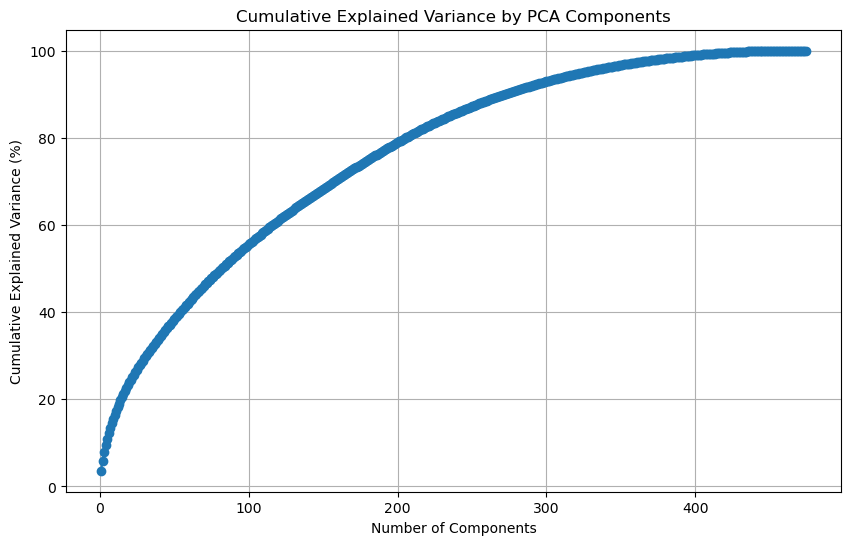

In [7]:
plt.figure(figsize=(10,6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance*100, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.grid(True)
plt.show()

In [8]:
#pca .95

In [9]:
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nNumber of components explaining 95% variance: {n_components}")


pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)


Number of components explaining 95% variance: 325


In [11]:
#splitt itttt 80 20

X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

# grid search

In [12]:
#parameters for the GS

In [14]:
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [5, 10, 15, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'bootstrap': [True, False]  
}


In [15]:
#lets fit the model

In [16]:

rf = RandomForestRegressor(random_state=123)

#Gsearch tune
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  
    n_jobs=-1,  
    verbose=2,  
    scoring='r2' 
)


print("okayyy starting the fit")
grid_search.fit(X_train_pca, y_train)

okayyy starting the fit
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=123), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=2)

In [17]:
#best parms

In [18]:
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print(f"\nBest parameters found by Grid Search: {best_params}")


Best parameters found by Grid Search: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [19]:
#optimized model

In [20]:
y_pred_best_rf = best_rf_model.predict(X_test_pca)

best_rf_r2 = r2_score(y_test, y_pred_best_rf)
best_rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))

print(f"\nOptimized Random Forest -- R² Score: {best_rf_r2:.4f}, RMSE: {best_rf_rmse:.4f}")


Optimized Random Forest -- R² Score: 0.1881, RMSE: 2.4713


In [22]:
#saving Gsearch

In [24]:
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results.to_excel('rumen_without_metadata_standar_PCA_optimized.xlsx', index=False)
print("done done done saved'")

done done done saved'
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   6.5s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  20.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  20.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  26.4s
[CV] END bootstrap=True, max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  19.2s
[CV] END bootstrap=True, max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  25.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  18.0s
[CV] END bootstrap=False, max_depth=5, m

[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  19.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  29.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  25.5s
[CV] END bootstrap=True, max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  27.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  10.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  28.6s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  29.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=

[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  19.7s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  20.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   9.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  26.9s
[CV] END bootstrap=True, max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   9.7s
[CV] END bootstrap=True, max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  27.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  10.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   9.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=

[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  19.5s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  13.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  10.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  27.8s
[CV] END bootstrap=True, max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   9.2s
[CV] END bootstrap=True, max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  19.2s
[CV] END bootstrap=True, max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  25.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  18.0s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, 

[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  19.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  41.5s
[CV] END bootstrap=True, max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.0s
[CV] END bootstrap=True, max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  27.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  18.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  26.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  29.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=

[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  13.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  13.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  10.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  27.9s
[CV] END bootstrap=True, max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   9.0s
[CV] END bootstrap=True, max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  19.1s
[CV] END bootstrap=True, max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  17.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, m